## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [ ]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [ ]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-26 19:02:27--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-26 19:02:27--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

AssertionError: Please, download `hw_overfitting_data_dict.npy` and place it in the working directory

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [ ]:
CUDA_DEVICE_ID = 0  # change if needed

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: tensor([6, 5, 1, 2, 4, 3, 3, 8, 6, 3, 0, 9, 2, 0, 8, 2, 3, 9, 4, 2, 1, 7, 9, 7,\n        8, 3, 4, 2, 1, 2, 4, 7])')

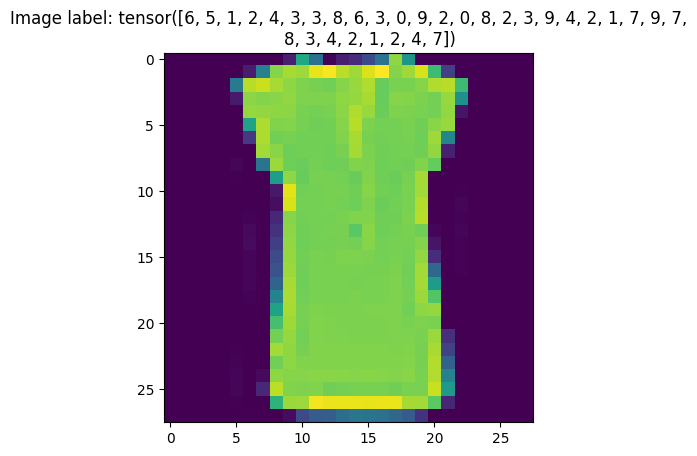

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________


In [ ]:
_label

tensor([6, 5, 1, 2, 4, 3, 3, 8, 6, 3, 0, 9, 2, 0, 8, 2, 3, 9, 4, 2, 1, 7, 9, 7,
        8, 3, 4, 2, 1, 2, 4, 7])

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [1]:
# Creating model instance
# your code here

class convmodel(nn.Module):
  def __init__(self):
      super().__init__()
      self.norm1=nn.BatchNorm2d(1)
      self.conv2=nn.Conv2d(1,5,3)
      self.conv3=nn.Conv2d(5,5,3)
      self.conv4=nn.Conv2d(5,5,3)
      self.relu=nn.ReLU()
      self.conv5=nn.Conv2d(5,5,3)
      self.maxp=nn.MaxPool2d(2)
      self.fc1=nn.Linear(405,10)
      self.flatten=nn.Flatten()


  def forward(self, x):
      x=self.norm1(x)
      x=self.fc1(self.relu(self.flatten(self.conv5(self.maxp(self.relu(self.conv4(self.relu(self.conv3(self.relu(self.conv2(x)))))))))))
      return x


NameError: name 'nn' is not defined

In [ ]:
model = convmodel() # your code here
device='cpu'
model=model.to(device)

In [ ]:
# Creating model instance

def train(model, loss_f, opt, train_data_loader, test_data_loader, num_epoch):
  for epoch in range(num_epoch):
    train_history=[]
    test_history=[]

    for image, label in tqdm(train_data_loader):
      temp=[]
      temp_test=[]

      opt.zero_grad()
      label_predicted=model(image.to(device))
      print(label_predicted.detach(), label.to(device))
      loss=loss_f(label_predicted, label.to(device))
      loss.backward()
      opt.step()
      temp.append(loss.item())
      break
    break
    train_history.append(np.mean(temp))

    with torch.no_grad():
      for image_test, label_test in tqdm(test_data_loader):
        label_predicted_test=model(image_test.to(device))
        loss_test=loss_f(label_predicted_test, label_test.to(device))
        temp_test.append(loss_test.item())
      test_history.append(np.mean(temp_test))

    print(train_history[-1])
    print(test_history[-1])
    print(epoch+1)
    print('\n')
  return model

loss_f=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model.parameters(),lr=0.0005)
num_epoch=5
model=train(model, loss_f, opt, train_data_loader, test_data_loader,num_epoch)

  0%|          | 0/1875 [00:00<?, ?it/s]

tensor([[ -0.2695,   2.1114,  -3.5282,   2.2684,  -2.2253,  -8.2491,  -2.1029,
          -6.3276,  -6.7584,  -7.3471],
        [ -1.3374,  -3.7976,   1.1990,  -3.1338,   1.3566,  -5.0760,   0.3493,
          -5.2864,  -0.7655,  -5.2463],
        [ -0.1938,  -2.8381,   1.9683,  -1.2535,   2.3370,  -4.3359,   1.6445,
          -4.1862,   0.5130,  -2.6033],
        [ -6.5949,  -9.6528,  -4.5046,  -8.3517,  -6.5102,   0.0379,  -5.8077,
          -3.4059,  -2.6478,  -1.6120],
        [ -4.3416,  -3.2198,   0.6167,  -7.4605,  -0.1060,  -2.0985,  -1.1380,
           0.3978,  -1.9489,  -4.7131],
        [ -3.9774,  -6.4384,  -2.7576,  -1.9779,  -1.9870,  -4.0855,  -2.2566,
          -4.4148,   1.4552,  -4.6336],
        [ -8.2325,  -9.8077,  -6.1626, -10.4413,  -8.4018,  -1.4813,  -7.0847,
          -3.5267,  -5.3918, -10.9287],
        [ -2.3675,  -3.8933,  -2.4995,   0.6328,  -0.9164,  -6.5995,  -1.3069,
          -6.4729,   0.2107,  -7.6349],
        [ -2.9659,  -2.2423,  -5.6494,  -0.2697,

Не забудьте перенести модель на выбранный `device`!

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

NameError: name 'model_task_1' is not defined

Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
# your code here

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
model_task_1=model
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.90088


In [ ]:
model_task_1=model
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8806


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

AssertionError: Train accuracy is below 0.885 threshold

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("C:/Users/Sergey/Downloads/submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!